Attempts to reproduce results in 10.1016/S0927-5398(02)00072-5.

In [1]:
from copy import deepcopy
from matplotlib import colors as mcolors
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm.notebook import tqdm, trange

from sde_models import Liesenfeld2003Univariate, Liesenfeld2003TwoComponent
import sde

store_ssr_data = True
load_ssr_data = False

fig_kwargs = dict(
    layout='compressed',
    figsize=(15.0, 3.0)
)
plot_all_kwargs = dict(
    color='gray',
    alpha=0.1
)
fig_compare_kwargs = dict(
    layout='compressed', 
    figsize=(8.0, 4.0)
)

t_fin = 4694  # IBM series
dt = 1.0  # Not reported
sample_size = 50
tested_sample_sizes = [25, 50, 100, 500, 1000, 5000, 10000]
confidence = 0.95
significance = 0.05

results_dir = os.path.join('results', '_'.join(Liesenfeld2003Univariate.name.split('_')[:2]))

def initial_values_uni(**kwargs):
    result = {'r': 0.0,
              'lam': 0.0}
    result.update(kwargs)
    return result

def initial_values_2comp(**kwargs):
    result = {'r': 0.0,
              'lam1': 0.0,
              'lam2': 0.0}
    result.update(kwargs)
    return result

In [2]:
num_steps = int(t_fin / dt)

if sde.get_pool() is None:
    sde.start_pool()

Generating results.

In [3]:
model_fig1 = Liesenfeld2003Univariate()
initial_values_fig1 = initial_values_uni()
parameters_fig1 = deepcopy(model_fig1.parameter_defaults)

results_fig1 = sde.execute_sample(sample_size, model_fig1, num_steps, dt, 
                                  initial_values=initial_values_fig1, parameters=parameters_fig1)

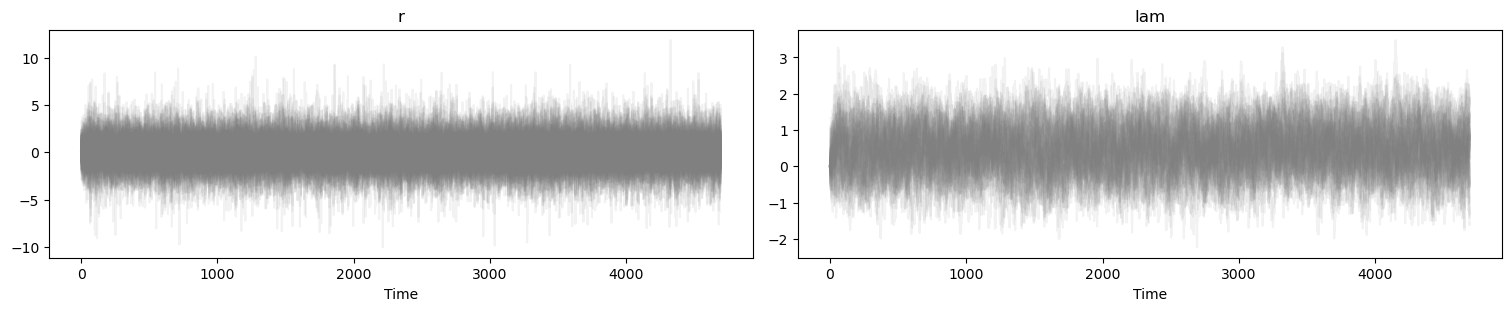

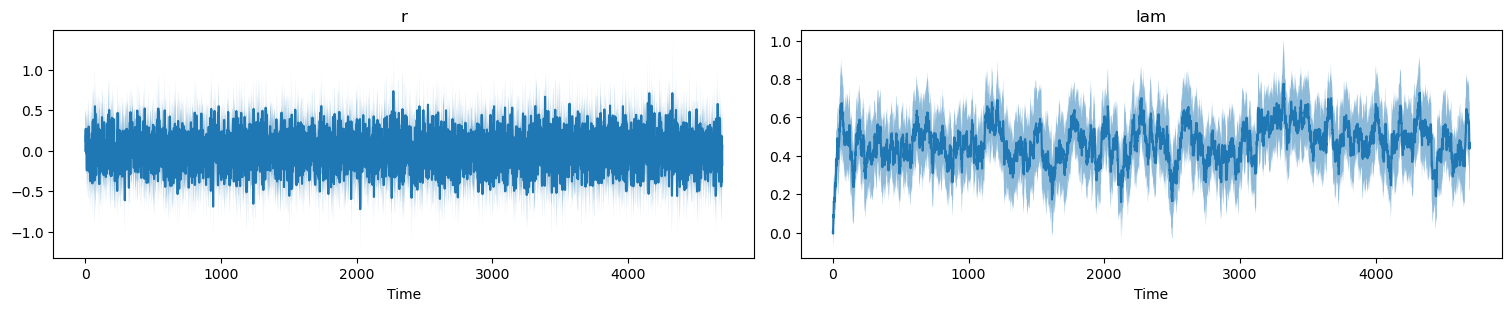

In [4]:
results_fig1.plot(fig_kwargs=fig_kwargs, plot_all_kwargs=plot_all_kwargs)

fig, axs = results_fig1.plot_ci(0.95, fig_kwargs=fig_kwargs, plot_all_kwargs=dict(alpha=0.5))
_ = results_fig1.plot_mean(fig_axs=(fig, axs))

Attempting to reproduce top row of Figure 1 and demonstrate that normalized residuals follow a standard normal.

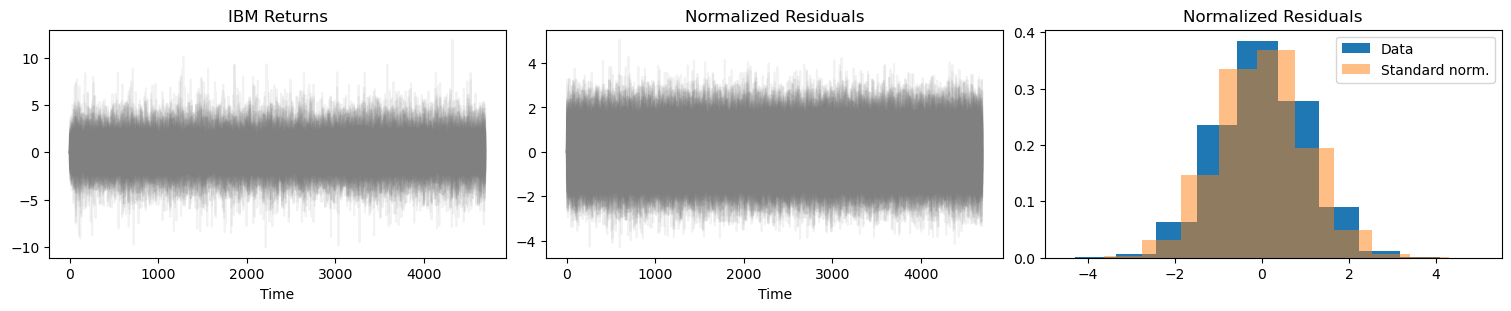

In [5]:
norm_residual_fig1 = results_fig1.data[:, 0, :] * np.exp(- results_fig1.data[:, 1, :] / 2.)

fig, axs = plt.subplots(1, 3, **fig_kwargs)

axs[0].plot(results_fig1.time, results_fig1.data[:, 0, :].T, alpha=0.1, color='gray')
axs[0].set_title('IBM Returns')
axs[0].set_xlabel('Time')

axs[1].plot(results_fig1.time, norm_residual_fig1.T, alpha=0.1, color='gray')
axs[1].set_title('Normalized Residuals')
axs[1].set_xlabel('Time')

axs[2].hist(norm_residual_fig1.flatten(), density=True, label='Data')
axs[2].hist(np.random.normal(size=norm_residual_fig1.flatten().shape[0]), alpha=0.5, density=True, label='Standard norm.')
axs[2].set_title('Normalized Residuals')
_ = axs[2].legend()

Attempting to reproduce Figure 5 and demonstrate that normalized residuals follow a standard normal.

In [6]:
model_fig5 = Liesenfeld2003TwoComponent()
initial_values_fig5 = initial_values_2comp()
parameters_fig5 = deepcopy(model_fig5.parameter_defaults)

results_fig5 = sde.execute_sample(sample_size, model_fig5, num_steps, dt, 
                                  initial_values=initial_values_fig5, parameters=parameters_fig5)

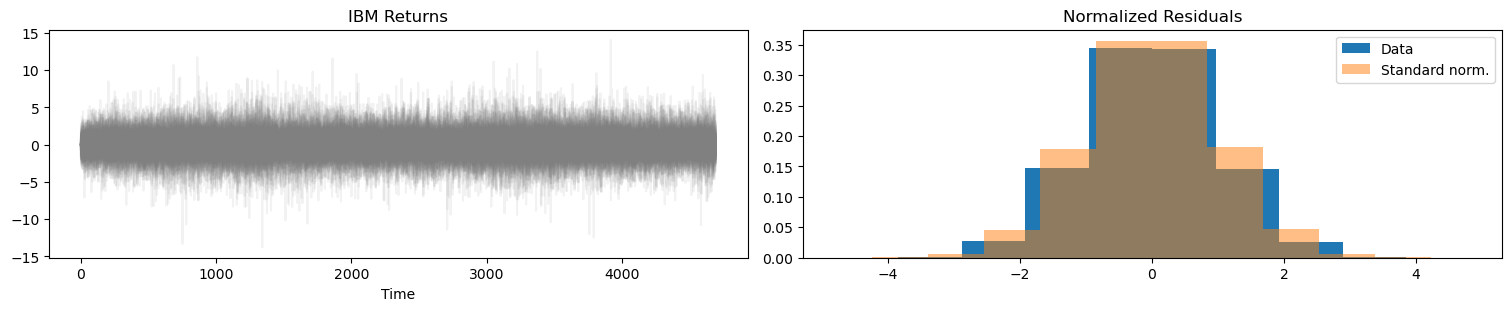

In [7]:
norm_residual_fig5 = results_fig5.data[:, 0, :] * np.exp(- (results_fig5.data[:, 1, :] + results_fig5.data[:, 2, :]) / 2.)

fig, axs = plt.subplots(1, 2, **fig_kwargs)

axs[0].plot(results_fig5.time, results_fig5.data[:, 0, :].T, alpha=0.1, color='gray')
axs[0].set_title('IBM Returns')
axs[0].set_xlabel('Time')

axs[1].hist(norm_residual_fig5.flatten(), density=True, label='Data')
axs[1].hist(np.random.normal(size=norm_residual_fig5.flatten().shape[0]), alpha=0.5, density=True, label='Standard norm.')
axs[1].set_title('Normalized Residuals')
_ = axs[1].legend()

Quantify reproducibility of the univariate SV model.

Univariate SV model EFECT Error (mean +- st. dev)
Sample size 25: 1.0152748861479794 +- 0.04382953461184937
Sample size 50: 0.7321242927330412 +- 0.03543587918093469
Sample size 100: 0.5200311073858532 +- 0.024313762437356282
Sample size 500: 0.23425836801174005 +- 0.010597011463567795
Sample size 1000: 0.16526200320546905 +- 0.007407524268286373
Sample size 5000: 0.07397416317404776 +- 0.003683383346008749
Sample size 10000: 0.05209278318931971 +- 0.002351288317465946


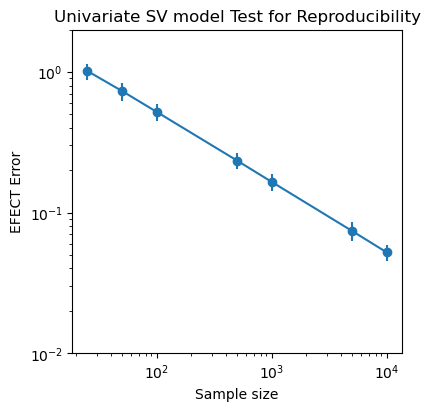

In [8]:
prefix_fig1 = 'results_fig1'

if load_ssr_data:
    md_data, res_data = sde.load_ssr_dataset(results_dir, prefix_fig1)[:2]
    ssr_metadata_fig1 = {}
    ssr_results_fig1 = {}
    for i in range(len(md_data)):
        ssr_metadata_fig1[md_data[i].sample_size] = md_data[i]
        ssr_results_fig1[md_data[i].sample_size] = res_data[i]
else:
    ssr_metadata_fig1, ssr_results_fig1 = sde.generate_ssr_dataset(
        Liesenfeld2003Univariate(),
        tested_sample_sizes,
        num_steps,
        dt,
        initial_values_fig1,
        parameters_fig1,
        prefix_fig1,
        results_dir=results_dir if store_ssr_data else None
    )

fig, ax = sde.plot_repro(ssr_metadata_fig1)
ax.set_title('Univariate SV model Test for Reproducibility')

print('Univariate SV model EFECT Error (mean +- st. dev)')
for sz, md in ssr_metadata_fig1.items():
    print(f'Sample size {sz}: {md.ks_stat_mean} +- {md.ks_stat_stdev}')

Quantify reproducibility of the two-component SV model.

Two-component SV model EFECT Error (mean +- st. dev)
Sample size 25: 1.0352492587291953 +- 0.04823429401144328
Sample size 50: 0.7409679667361779 +- 0.034820638040011766
Sample size 100: 0.5271056689270258 +- 0.023162061087281145
Sample size 500: 0.23708177992398652 +- 0.010374832415143954
Sample size 1000: 0.16814631218445036 +- 0.007657110416793893
Sample size 5000: 0.07527678428209328 +- 0.0035207800101809627
Sample size 10000: 0.0530872379172812 +- 0.002420302692305166


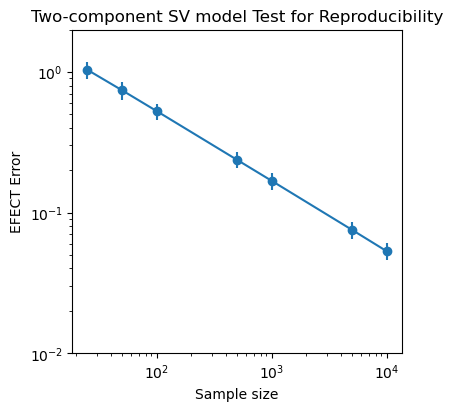

In [9]:
prefix_fig5 = 'results_fig5'

if load_ssr_data:
    md_data, res_data = sde.load_ssr_dataset(results_dir, prefix_fig5)[:2]
    ssr_metadata_fig5 = {}
    ssr_results_fig5 = {}
    for i in range(len(md_data)):
        ssr_metadata_fig5[md_data[i].sample_size] = md_data[i]
        ssr_results_fig5[md_data[i].sample_size] = res_data[i]
else:
    ssr_metadata_fig5, ssr_results_fig5 = sde.generate_ssr_dataset(
        Liesenfeld2003TwoComponent(),
        tested_sample_sizes,
        num_steps,
        dt,
        initial_values_fig5,
        parameters_fig5,
        prefix_fig5,
        results_dir=results_dir if store_ssr_data else None
    )

fig, ax = sde.plot_repro(ssr_metadata_fig5)
ax.set_title('Two-component SV model Test for Reproducibility')

print('Two-component SV model EFECT Error (mean +- st. dev)')
for sz, md in ssr_metadata_fig5.items():
    print(f'Sample size {sz}: {md.ks_stat_mean} +- {md.ks_stat_stdev}')

Generate reproducible Figure 1 results.

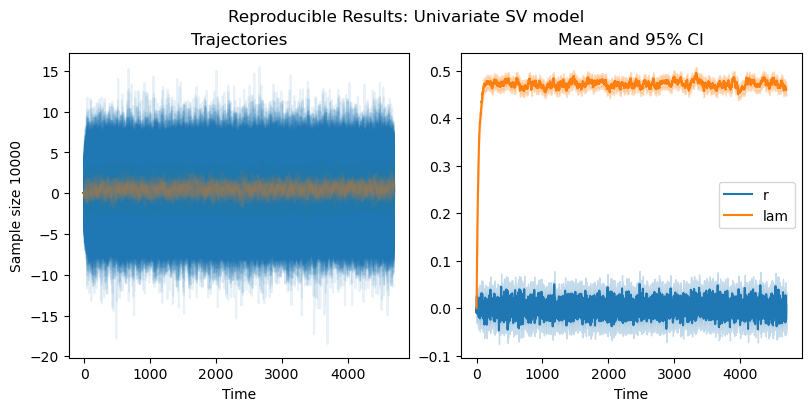

In [10]:
fig, axs = plt.subplots(1, 2, **fig_compare_kwargs)

plot_colors = {
    Liesenfeld2003Univariate.variable_names[i]: list(mcolors.TABLEAU_COLORS.values())[i] 
    for i in range(len(Liesenfeld2003Univariate.variable_names))
}

ssr_results_sz = max(ssr_results_fig1.keys())

r: sde.SDEResultSample = ssr_results_fig1[ssr_results_sz]
r.plot(fig_axs=(fig, [axs[0]] * len(Liesenfeld2003Univariate().variable_names)),
       plot_all_kwargs=dict(alpha=0.1),
       plot_kwargs={n: dict(color=plot_colors[n]) 
                    for n in Liesenfeld2003Univariate().variable_names})

r.plot_ci(confidence, fig_axs=(fig, [axs[1]] * len(Liesenfeld2003Univariate().variable_names)),
          plot_all_kwargs=dict(alpha=0.25),
          plot_kwargs={n: dict(color=plot_colors[n]) 
                       for n in Liesenfeld2003Univariate().variable_names})
r.plot_mean(fig_axs=(fig, [axs[1]] * len(Liesenfeld2003Univariate().variable_names)),
            plot_kwargs={n: dict(color=plot_colors[n], label=n) 
                         for n in Liesenfeld2003Univariate().variable_names})

fig.suptitle('Reproducible Results: Univariate SV model')
axs[0].set_title('Trajectories')
axs[1].set_title(f'Mean and {int(confidence * 100)}% CI')
axs[0].set_ylabel(f'Sample size {ssr_results_sz}')
_ = axs[1].legend()

Generate reproducible Figure 5 results.

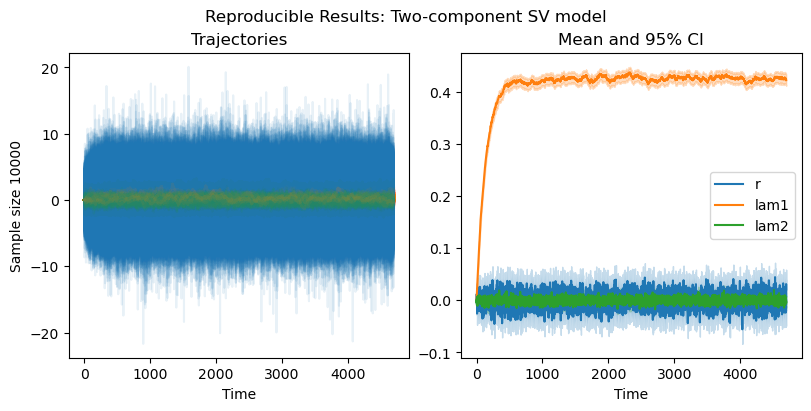

In [11]:
fig, axs = plt.subplots(1, 2, **fig_compare_kwargs)

plot_colors = {
    Liesenfeld2003TwoComponent.variable_names[i]: list(mcolors.TABLEAU_COLORS.values())[i] 
    for i in range(len(Liesenfeld2003TwoComponent.variable_names))
}

ssr_results_sz = max(ssr_results_fig5.keys())

r: sde.SDEResultSample = ssr_results_fig5[ssr_results_sz]
r.plot(fig_axs=(fig, [axs[0]] * len(Liesenfeld2003TwoComponent().variable_names)),
       plot_all_kwargs=dict(alpha=0.1),
       plot_kwargs={n: dict(color=plot_colors[n]) 
                    for n in Liesenfeld2003TwoComponent().variable_names})

r.plot_ci(confidence, fig_axs=(fig, [axs[1]] * len(Liesenfeld2003TwoComponent().variable_names)),
          plot_all_kwargs=dict(alpha=0.25),
          plot_kwargs={n: dict(color=plot_colors[n]) 
                       for n in Liesenfeld2003TwoComponent().variable_names})
r.plot_mean(fig_axs=(fig, [axs[1]] * len(Liesenfeld2003TwoComponent().variable_names)),
            plot_kwargs={n: dict(color=plot_colors[n], label=n) 
                         for n in Liesenfeld2003TwoComponent().variable_names})

fig.suptitle('Reproducible Results: Two-component SV model')
axs[0].set_title('Trajectories')
axs[1].set_title(f'Mean and {int(confidence * 100)}% CI')
axs[0].set_ylabel(f'Sample size {ssr_results_sz}')
_ = axs[1].legend()

Set up for precision tests.

In [12]:
num_eval_pts = 7
num_eval_se = 3

repro_colors = list(mcolors.BASE_COLORS.values())


def test_precision(model,
                   parameters,
                   ssr_results,
                   ssr_metadata,
                   se):

    bounds_tested = {
        k: (model.parameter_defaults[k] - se[k] * num_eval_se, 
            model.parameter_defaults[k] + se[k] * num_eval_se) 
        for k in se.keys()
    }

    vals_precision_tested = {}
    for name, name_bounds in bounds_tested.items():
        name_vals = np.linspace(*name_bounds, num_eval_pts)
        val_ratios = [max(0.0, x / parameters[name]) for x in name_vals]
        if 1.0 not in val_ratios:
            val_ratios.append(1.0)
            val_ratios.sort()
        vals_precision_tested[name] = val_ratios

    md_precision_tested = {name: {} for name in bounds_tested.keys()}
    pvals_precision_tested = {name: {} for name in bounds_tested.keys()}

    for sz in tqdm(tested_sample_sizes, leave=False):
        for name, name_bounds in tqdm(bounds_tested.items(), desc=f'Size {sz}', leave=False):
            err, pval = sde.test_precision_params(
                ssr_results[sz],
                model(),
                name,
                vals_precision_tested[name],
                (ssr_metadata[sz].ks_stat_mean, ssr_metadata[sz].ks_stat_stdev),
                parameters
            )
            md_precision_tested[name][sz], pvals_precision_tested[name][sz] = err, pval

    return bounds_tested, vals_precision_tested, md_precision_tested, pvals_precision_tested


def plot_precision_efect(ssr_metadata,
                         vals_precision_tested,
                         md_precision_tested):
    err_stats = {name: {k: (v.ks_stat_mean, v.ks_stat_stdev) for k, v in ssr_metadata.items()} 
                 for name in vals_precision_tested.keys()}
    repro_colors = list(mcolors.BASE_COLORS.values())
    
    result = []

    for i, name in tqdm(enumerate(md_precision_tested.keys()), total=len(md_precision_tested.keys()), leave=False):
        fig, axs = plt.subplots(1, 1, layout='compressed', figsize=(6.0, 3.0))

        data = md_precision_tested[name]
        sde.plot_precision(
            err_stats[name],
            vals_precision_tested[name],
            data,
            fig_axs=(fig, [axs] * len(data.keys())),
            scatter_plot_kwargs={sz: dict(label=f'Sample size={sz}', 
                                          color=repro_colors[j % len(repro_colors)]) 
                                 for j, sz in enumerate(data.keys())},
            fill_plot_kwargs={sz: dict(color=repro_colors[j % len(repro_colors)]) 
                              for j, sz in enumerate(data.keys())}
        )
        axs.set_xlabel(f'Parameter ratio: {name}')
        axs.set_ylabel(f'EFECT Error')
        axs.legend()

        for i in trange(len(vals_precision_tested[name]), desc=name, leave=False):
            if vals_precision_tested[name][i] == 1.0:
                for j, sz in enumerate(tested_sample_sizes):
                    axs.scatter([vals_precision_tested[name][i]], 
                                [md_precision_tested[name][sz][i]], 
                                s=100, 
                                color=repro_colors[j % len(repro_colors)],
                                marker='*')

        result.append((fig, axs))

    return result


def plot_precision_pval(vals_precision_tested,
                        md_precision_tested,
                        pvals_precision_tested):
    result = []
    
    for i, name in tqdm(enumerate(md_precision_tested.keys()), total=len(md_precision_tested.keys()), leave=False):
        data = md_precision_tested[name]

        fig, axs = plt.subplots(1, 1, layout='compressed', figsize=(6.0, 3.0))

        sde.plot_precision_test(
            pvals_precision_tested[name],
            vals_precision_tested[name],
            significance,
            fig_axs=(fig, [axs] * len(data.keys())),
            plot_kwargs={sz: dict(color=repro_colors[j % len(repro_colors)]) 
                         for j, sz in enumerate(data.keys())},
            scatter_kwargs={sz: dict(label=f'Sample size={sz}', 
                                     color=repro_colors[j % len(repro_colors)]) 
                            for j, sz in enumerate(data.keys())}
        )
        axs.set_xlabel(f'Parameter ratio: {name}')
        axs.set_ylabel(f'Rejection p-value')
        axs.legend()

        for i in trange(len(vals_precision_tested[name]), desc=name, leave=False):
            if vals_precision_tested[name][i] == 1.0:
                for j, sz in enumerate(tested_sample_sizes):
                    axs.scatter([vals_precision_tested[name][i]], 
                                [pvals_precision_tested[name][sz][i]], 
                                s=100, 
                                color=repro_colors[j % len(repro_colors)],
                                marker='*')

        result.append((fig, axs))

    return result


def precision_summary_table(vals_precision_tested,
                            pvals_precision_tested,
                            parameters,
                            se):
    key_down = 'Decreasing difference (# SEs)'
    key_up = 'Increasing difference (# SEs)'
    summary_data = {
        'Sample size': [],
        'Parameter': [],
        key_down: [],
        key_up: []
    }
    detection_status = []
    for name, name_data in pvals_precision_tested.items():
        for sample_size, sample_data in name_data.items():
            detected_se_neg_i = None
            detected_se_pos_i = None
            for i, pval in enumerate(sample_data):
                num_se_i = float(np.round((vals_precision_tested[name][i] - 1.0) * parameters[name] / se[name], 1))
                if num_se_i == 0.0:
                    continue
                correct_i = pval < significance
                if correct_i:
                    if num_se_i < 0:
                        if detected_se_neg_i is None or abs(num_se_i) < abs(detected_se_neg_i):
                            detected_se_neg_i = num_se_i
                    else:
                        if detected_se_pos_i is None or num_se_i < detected_se_pos_i:
                            detected_se_pos_i = num_se_i
            
            if detected_se_neg_i == -1.0 and detected_se_pos_i == 1.0:
                detection_status.append(0)
            elif detected_se_neg_i is not None and detected_se_pos_i is not None:
                detection_status.append(1)
            elif detected_se_neg_i is not None or detected_se_pos_i is not None:
                detection_status.append(2)
            else:
                detection_status.append(3)

            summary_data['Parameter'].append(name)
            summary_data['Sample size'].append(sample_size)
            summary_data[key_down].append(detected_se_neg_i)
            summary_data[key_up].append(detected_se_pos_i)

    def custom_formatter_neg(x):
        if pd.isna(x):
            return f'<-{num_eval_se}'
        return str(int(x))

    def custom_formatter_pos(x):
        if pd.isna(x):
            return f'>{num_eval_se}'
        return str(int(x))

    def highlight_all_detected(row):
        status_colors = [
            'background-color: rgba(0, 255, 0, 0.25)',
            'background-color: rgba(175, 255, 0, 0.25)',
            'background-color: rgba(255, 175, 0, 0.25)',
            'background-color: rgba(255, 0, 0, 0.25)'
        ]
        return [status_colors[detection_status_sorted[i]] for i in range(len(row))]

    df_summary_data = pd.DataFrame(summary_data)
    df_summary_data = df_summary_data.sort_values(by=['Sample size', 'Parameter'])

    detection_status_sorted = [detection_status[idx] for idx, _ in df_summary_data.iterrows()]

    df_summary_data.set_index(['Sample size', 'Parameter'], inplace=True)
    df_summary_data_styled = df_summary_data.style.set_caption('Detectable parametric differences from nominal')
    df_summary_data_styled = df_summary_data_styled.format({key_down: custom_formatter_neg, 
                                                            key_up: custom_formatter_pos})
    df_summary_data_styled = df_summary_data_styled.apply(highlight_all_detected, axis=0)
    return df_summary_data_styled

Test precision of published sample reproducibility on the order of reported standard error for Figure 1 according to Table 1. The test increases or decreases each fitted parameter from its reported nominal value by a magnitude of 1, 2, or 3 reported standard errors. 

We find that for the reported sample size of 50, we can only detect parametric differences in $\delta$ that are at least three standard errors greater than nominal. Otherwise, we cannot detect any parametric difference of three standard errors or less with the reported sample size. 

We also find that a sample size of 5,000 would have allowed detection of increasing or decreasing parametric differences of magnitude greater than or equal to one standard error. 

In [13]:
se_fig1 = {
    'gam': 0.005,
    'delta': 0.009,
    'nu': 0.021
}
pt_fig1 = test_precision(Liesenfeld2003Univariate,
                         parameters_fig1,
                         ssr_results_fig1,
                         ssr_metadata_fig1,
                         se_fig1)
bounds_tested_fig1, vals_precision_tested_fig1, md_precision_tested_fig1, pvals_precision_tested_fig1 = pt_fig1

  0%|          | 0/7 [00:00<?, ?it/s]

Size 25:   0%|          | 0/3 [00:00<?, ?it/s]

Size 50:   0%|          | 0/3 [00:00<?, ?it/s]

Size 100:   0%|          | 0/3 [00:00<?, ?it/s]

Size 500:   0%|          | 0/3 [00:00<?, ?it/s]

Size 1000:   0%|          | 0/3 [00:00<?, ?it/s]

Size 5000:   0%|          | 0/3 [00:00<?, ?it/s]

Size 10000:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

gam:   0%|          | 0/7 [00:00<?, ?it/s]

delta:   0%|          | 0/7 [00:00<?, ?it/s]

nu:   0%|          | 0/7 [00:00<?, ?it/s]

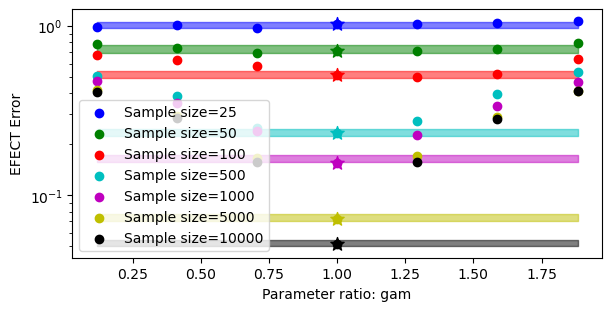

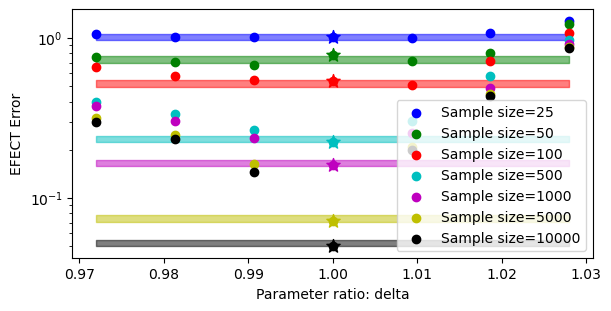

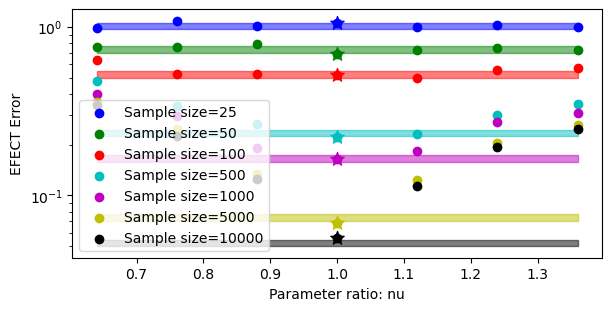

In [14]:
_ = plot_precision_efect(ssr_metadata_fig1, vals_precision_tested_fig1, md_precision_tested_fig1)

  0%|          | 0/3 [00:00<?, ?it/s]

gam:   0%|          | 0/7 [00:00<?, ?it/s]

delta:   0%|          | 0/7 [00:00<?, ?it/s]

nu:   0%|          | 0/7 [00:00<?, ?it/s]

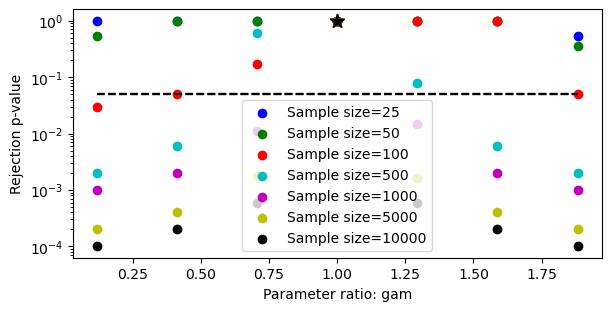

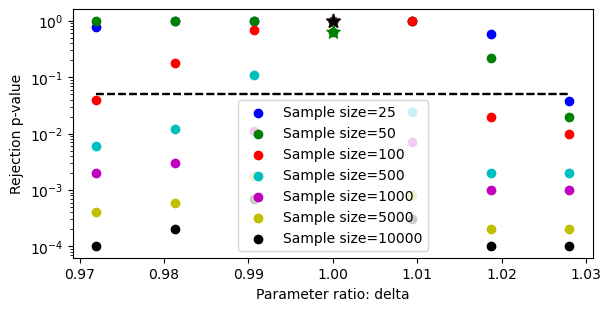

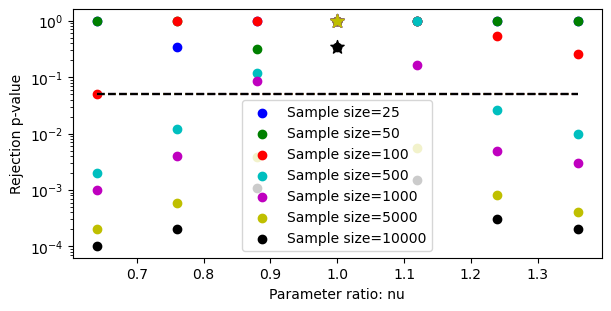

In [15]:
_ = plot_precision_pval(vals_precision_tested_fig1, md_precision_tested_fig1, pvals_precision_tested_fig1)

In [203]:
df_summary_data_fig1 = precision_summary_table(vals_precision_tested_fig1,
                                               pvals_precision_tested_fig1,
                                               parameters_fig1,
                                               se_fig1)
df_summary_data_fig1

Test precision of published sample reproducibility on the order of reported standard error for Figure 5 according to Table 7. The test increases or decreases each fitted parameter from its reported nominal value by a magnitude of 1, 2, or 3 reported standard errors. 

We find that for the reported sample size of 50, we can only detect parametric differences in $\delta_1$ that are at least two standard errors greater than nominal, and in $\nu_1$ that are at least three standard errors less than nominal. Otherwise, we cannot detect any parametric difference of three standard errors or less with the reported sample size. 

We also find that a sample size of 10,000 would have allowed detection of increasing or decreasing parametric differences of magnitude greater than or equal to one standard error. 

In [16]:
se_fig5 = {
    'gam1': 0.001,
    'delta1': 0.003,
    'nu1': 0.012,
    'delta2': 0.158,
    'nu2': 0.048
}
pt_fig5 = test_precision(Liesenfeld2003TwoComponent,
                         parameters_fig5,
                         ssr_results_fig5,
                         ssr_metadata_fig5,
                         se_fig5)
bounds_tested_fig5, vals_precision_tested_fig5, md_precision_tested_fig5, pvals_precision_tested_fig5 = pt_fig5

  0%|          | 0/7 [00:00<?, ?it/s]

Size 25:   0%|          | 0/5 [00:00<?, ?it/s]

Size 50:   0%|          | 0/5 [00:00<?, ?it/s]

Size 100:   0%|          | 0/5 [00:00<?, ?it/s]

Size 500:   0%|          | 0/5 [00:00<?, ?it/s]

Size 1000:   0%|          | 0/5 [00:00<?, ?it/s]

Size 5000:   0%|          | 0/5 [00:00<?, ?it/s]

Size 10000:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

gam1:   0%|          | 0/7 [00:00<?, ?it/s]

delta1:   0%|          | 0/7 [00:00<?, ?it/s]

nu1:   0%|          | 0/7 [00:00<?, ?it/s]

delta2:   0%|          | 0/7 [00:00<?, ?it/s]

nu2:   0%|          | 0/7 [00:00<?, ?it/s]

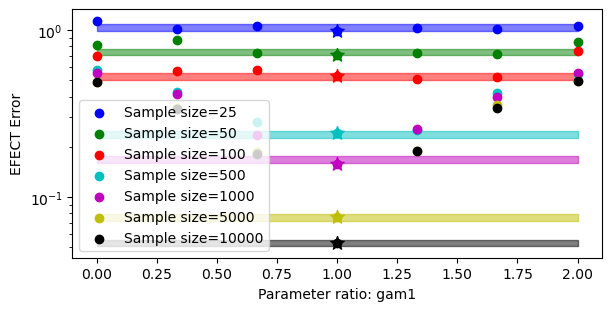

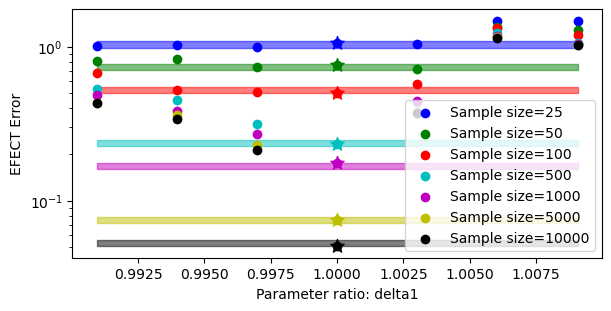

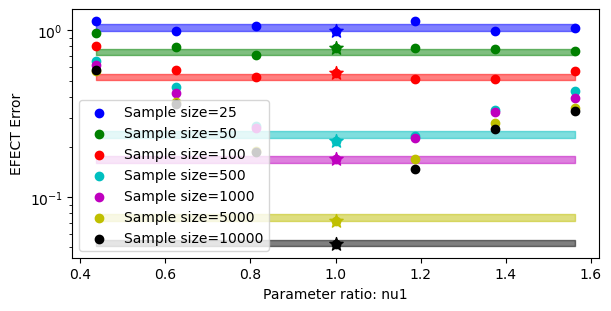

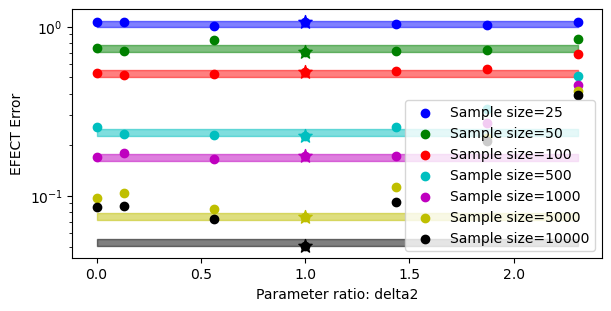

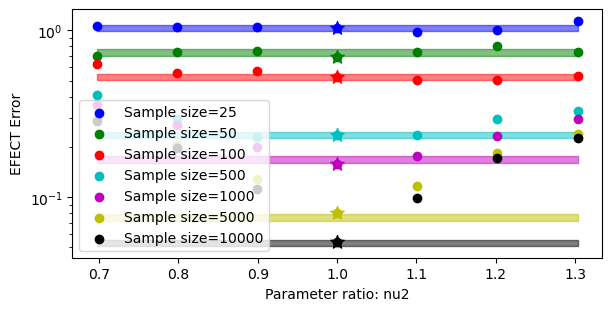

In [17]:
_ = plot_precision_efect(ssr_metadata_fig5, vals_precision_tested_fig5, md_precision_tested_fig5)

  0%|          | 0/5 [00:00<?, ?it/s]

gam1:   0%|          | 0/7 [00:00<?, ?it/s]

delta1:   0%|          | 0/7 [00:00<?, ?it/s]

nu1:   0%|          | 0/7 [00:00<?, ?it/s]

delta2:   0%|          | 0/7 [00:00<?, ?it/s]

nu2:   0%|          | 0/7 [00:00<?, ?it/s]

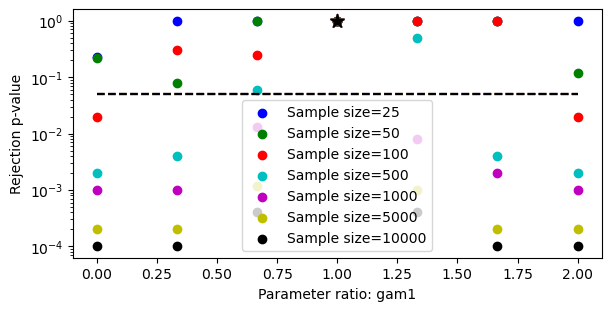

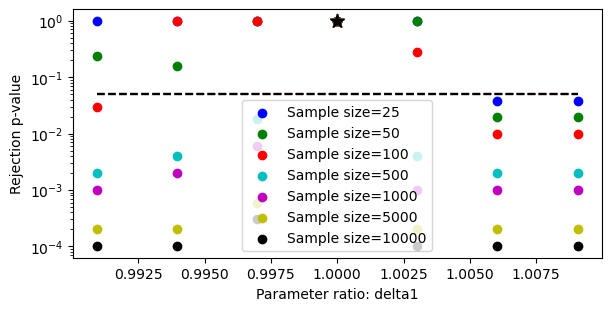

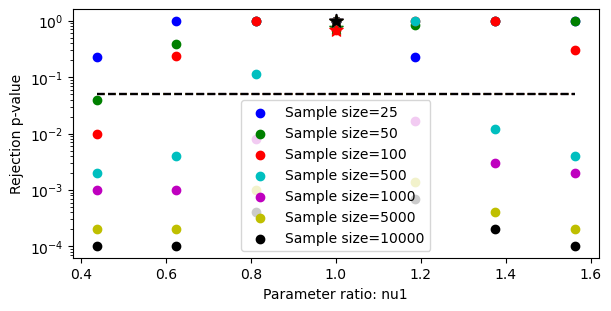

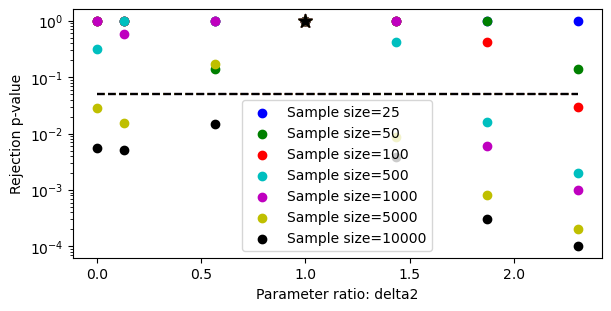

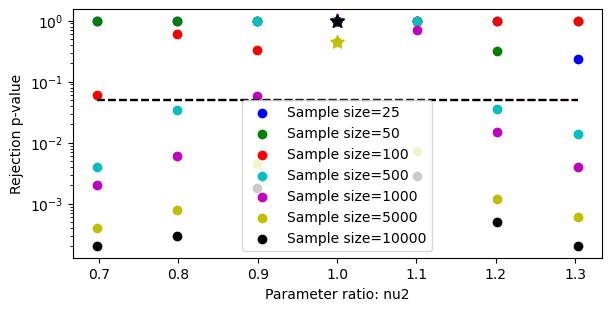

In [18]:
_ = plot_precision_pval(vals_precision_tested_fig5, md_precision_tested_fig5, pvals_precision_tested_fig5)

In [204]:
df_summary_data_fig5 = precision_summary_table(vals_precision_tested_fig5,
                                               pvals_precision_tested_fig5,
                                               parameters_fig5,
                                               se_fig5)
df_summary_data_fig5